In [202]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import random
pd.set_option('display.max_colwidth', 255)

In [247]:
def LSTM_model(X_train, dropout):
    ##model
    model = Sequential()

    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))

    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(dropout))

    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(dropout))

    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(dropout))

    # Adding the output layer
    model.add(Dense(units = 1))
    
    return model

In [41]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

## Reading Data

In [3]:
df_res_index = pd.read_csv('results_with_indexes.csv')

In [4]:
df_res_index.columns

Index(['Unnamed: 0', 'date', 'content', 'stock', 'source', 'Day', 'Month',
       'Hour', 'Minute', 'DayofWeek', 'trading_hours', 'pre_trading',
       'post_trading', 'price', 'Sentiment_textblob', 'Sentiment_vader',
       'just_date', 'Open_SnP', 'High_SnP', 'Low_SnP', 'Close_SnP',
       'Adj Close_SnP', 'Volume_SnP', 'Open_NASDAQ', 'High_NASDAQ',
       'Low_NASDAQ', 'Close_NASDAQ', 'Adj Close_NASDAQ', 'Volume_NASDAQ',
       'Open_DJIA', 'High_DJIA', 'Low_DJIA', 'Close_DJIA', 'Adj Close_DJIA',
       'Volume_DJIA', 'Date', 'Open_wilshire', 'High_wilshire', 'Low_wilshire',
       'Close_wilshire', 'Adj Close_wilshire', 'Volume_wilshire'],
      dtype='object')

In [5]:
df_tfidf = pd.read_csv('tfidf_wordvec.csv')

In [6]:
df_tfidf

,date,stock,combined_content,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-08-18 10:45:00,GME,let buy gme,0.000000,0.000000,0.0,0.0,0.748792,0.000000,0.662806,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2021-08-18 12:45:00,MVIS,mvis time shine,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
2,2021-08-18 13:45:00,AMC,think run story amc gme second spike think matter earning like today,0.000000,0.386051,0.0,0.0,0.000000,0.000000,0.408582,...,0.000000,0.000000,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.0
3,2021-08-18 13:45:00,GME,think run story amc gme second spike think matter earning like today,0.000000,0.386051,0.0,0.0,0.000000,0.000000,0.408582,...,0.000000,0.000000,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.0
4,2021-08-18 14:45:00,AMC,taliban want buy amc,0.000000,0.641551,0.0,0.0,0.767080,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,2021-09-18 19:45:00,GME,"alert run gain daily alert one time fee beat that link bio,inc ipo price bestinc billion usd revenue quarter mkcap million,squeeze,know shit manipulate short interest info stock basically publicly available source skew heavily right publish article gl...",0.670619,0.145040,0.0,0.0,0.173419,0.000000,0.153505,...,0.000000,0.204094,0.322781,0.000000,0.345118,0.196776,0.300012,0.286217,0.000000,0.0
6008,2021-09-18 19:45:00,MVIS,"alert run gain daily alert one time fee beat that link bio,alert run gain daily alert one time fee beat that link bio",0.841013,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.404794,0.000000,0.000000,0.000000,0.000000,0.358941,0.000000,0.0
6009,2021-09-18 19:45:00,AMC,"government want citizen protect citizen market manipulation survival rate virus, ,rarely follow news big dip billion allocate develop hedera ecosystem settlement relist exchange corporation accept payment grayscale invest these,spacexs private inspira...",0.551951,0.596876,0.0,0.0,0.000000,0.150584,0.126342,...,0.157072,0.167979,0.265664,0.000000,0.000000,0.161956,0.123462,0.235571,0.000000,0.0
6010,2021-09-18 20:00:00,AMC,"aggressivevolatile high short squeeze stock potential big return equally sustain loss pdyo,owner amc share amc movie sport add football amazing,awesome idea also cool announce news weekend rest short lol,double benny,routinely drive past cinemark near...",0.000000,0.529425,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.345020,0.629873,0.359134,0.273775,0.000000,0.000000,0.0


In [7]:
df_open = df_res_index[['date', 'content', 'stock', 'pre_trading', 'post_trading', 'price', 'Sentiment_textblob', 'Sentiment_vader', 'Close_DJIA', 'Open_DJIA', 'Volume_SnP', 'Open_SnP']]

In [8]:
df_open.head()

,date,content,stock,pre_trading,post_trading,price,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,Open_SnP
0,2021-09-17 23:45:00,like say look matter see,GME,0,0,205.01,0.000000,0.3818,34584.878906,34737.859375,5622210000,4469.740234
1,2021-09-17 23:45:00,see moonday market open until then out find moment zen mentally prepare rain shine ready all,GME,0,0,205.01,0.033333,0.3612,34584.878906,34737.859375,5622210000,4469.740234
2,2021-09-17 23:45:00,only human comprehend crypto early regulation harm good but wtf know,GME,0,0,205.01,0.060000,-0.7579,34584.878906,34737.859375,5622210000,4469.740234
3,2021-09-17 23:45:00,late article write medium what cellar box cellar box the predatory secret that wall street use exploit infinite money glitch stock market,GME,0,0,205.01,-0.350000,-0.1027,34584.878906,34737.859375,5622210000,4469.740234
4,2021-09-17 23:45:00,2nd mention 4chan day,GME,0,0,205.01,0.000000,0.0000,34584.878906,34737.859375,5622210000,4469.740234


In [9]:
df_res_index.head()

,Unnamed: 0,date,content,stock,source,Day,Month,Hour,Minute,DayofWeek,...,Close_DJIA,Adj Close_DJIA,Volume_DJIA,Date,Open_wilshire,High_wilshire,Low_wilshire,Close_wilshire,Adj Close_wilshire,Volume_wilshire
0,0,2021-09-17 23:45:00,like say look matter see,GME,Twitter,17,9,23,45,5,...,34584.878906,34584.878906,560630000,2021-09-17,46491.269531,46496.871094,46064.058594,46143.710938,46143.710938,0
1,1,2021-09-17 23:45:00,see moonday market open until then out find moment zen mentally prepare rain shine ready all,GME,Twitter,17,9,23,45,5,...,34584.878906,34584.878906,560630000,2021-09-17,46491.269531,46496.871094,46064.058594,46143.710938,46143.710938,0
2,2,2021-09-17 23:45:00,only human comprehend crypto early regulation harm good but wtf know,GME,Twitter,17,9,23,45,5,...,34584.878906,34584.878906,560630000,2021-09-17,46491.269531,46496.871094,46064.058594,46143.710938,46143.710938,0
3,3,2021-09-17 23:45:00,late article write medium what cellar box cellar box the predatory secret that wall street use exploit infinite money glitch stock market,GME,Twitter,17,9,23,45,5,...,34584.878906,34584.878906,560630000,2021-09-17,46491.269531,46496.871094,46064.058594,46143.710938,46143.710938,0
4,4,2021-09-17 23:45:00,2nd mention 4chan day,GME,Twitter,17,9,23,45,5,...,34584.878906,34584.878906,560630000,2021-09-17,46491.269531,46496.871094,46064.058594,46143.710938,46143.710938,0


In [10]:
df_final = pd.merge(df_open, df_tfidf, left_on = ['date', 'stock'], right_on = ['date', 'stock'])

In [11]:
df_final.head()

,date,content,stock,pre_trading,post_trading,price,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-09-17 23:45:00,like say look matter see,GME,0,0,205.01,0.000000,0.3818,34584.878906,34737.859375,...,0.522609,0.0,0.0,0.258841,0.236272,0.26943,0.205392,0.0,0.0,0.0
1,2021-09-17 23:45:00,see moonday market open until then out find moment zen mentally prepare rain shine ready all,GME,0,0,205.01,0.033333,0.3612,34584.878906,34737.859375,...,0.522609,0.0,0.0,0.258841,0.236272,0.26943,0.205392,0.0,0.0,0.0
2,2021-09-17 23:45:00,only human comprehend crypto early regulation harm good but wtf know,GME,0,0,205.01,0.060000,-0.7579,34584.878906,34737.859375,...,0.522609,0.0,0.0,0.258841,0.236272,0.26943,0.205392,0.0,0.0,0.0
3,2021-09-17 23:45:00,late article write medium what cellar box cellar box the predatory secret that wall street use exploit infinite money glitch stock market,GME,0,0,205.01,-0.350000,-0.1027,34584.878906,34737.859375,...,0.522609,0.0,0.0,0.258841,0.236272,0.26943,0.205392,0.0,0.0,0.0
4,2021-09-17 23:45:00,2nd mention 4chan day,GME,0,0,205.01,0.000000,0.0000,34584.878906,34737.859375,...,0.522609,0.0,0.0,0.258841,0.236272,0.26943,0.205392,0.0,0.0,0.0


## GME

In [12]:
df_gme_prices = df_final[df_final['stock'] == 'GME']

In [13]:
df_gme_prices

,date,content,stock,pre_trading,post_trading,price,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-09-17 23:45:00,like say look matter see,GME,0,0,205.010000,0.000000,0.3818,34584.878906,34737.859375,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
1,2021-09-17 23:45:00,see moonday market open until then out find moment zen mentally prepare rain shine ready all,GME,0,0,205.010000,0.033333,0.3612,34584.878906,34737.859375,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
2,2021-09-17 23:45:00,only human comprehend crypto early regulation harm good but wtf know,GME,0,0,205.010000,0.060000,-0.7579,34584.878906,34737.859375,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
3,2021-09-17 23:45:00,late article write medium what cellar box cellar box the predatory secret that wall street use exploit infinite money glitch stock market,GME,0,0,205.010000,-0.350000,-0.1027,34584.878906,34737.859375,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
4,2021-09-17 23:45:00,2nd mention 4chan day,GME,0,0,205.010000,0.000000,0.0000,34584.878906,34737.859375,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62552,2021-08-18 20:00:00,stock crater that cost,GME,0,1,156.760000,0.000000,0.0000,34960.691406,35310.199219,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
62553,2021-08-18 20:00:00,wait coworkers moass specially boss make fun amctothemoon time say before laugh end amcmoass,GME,0,1,156.760000,0.319048,0.7845,34960.691406,35310.199219,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
62554,2021-08-18 20:00:00,alert run gain daily alert one time fee beat that link bio,GME,0,1,156.760000,0.000000,0.7783,34960.691406,35310.199219,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
62555,2021-08-18 13:45:00,think run story amc gme second spike think matter earning like today,GME,0,0,159.220001,0.000000,0.3818,34960.691406,35310.199219,...,0.000000,0.0,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.0


In [14]:
df_gme_prices = df_gme_prices.drop(columns = ['content'])
df_gme_prices

,date,stock,pre_trading,post_trading,price,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-09-17 23:45:00,GME,0,0,205.010000,0.000000,0.3818,34584.878906,34737.859375,5622210000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
1,2021-09-17 23:45:00,GME,0,0,205.010000,0.033333,0.3612,34584.878906,34737.859375,5622210000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
2,2021-09-17 23:45:00,GME,0,0,205.010000,0.060000,-0.7579,34584.878906,34737.859375,5622210000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
3,2021-09-17 23:45:00,GME,0,0,205.010000,-0.350000,-0.1027,34584.878906,34737.859375,5622210000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
4,2021-09-17 23:45:00,GME,0,0,205.010000,0.000000,0.0000,34584.878906,34737.859375,5622210000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62552,2021-08-18 20:00:00,GME,0,1,156.760000,0.000000,0.0000,34960.691406,35310.199219,2965210000,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
62553,2021-08-18 20:00:00,GME,0,1,156.760000,0.319048,0.7845,34960.691406,35310.199219,2965210000,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
62554,2021-08-18 20:00:00,GME,0,1,156.760000,0.000000,0.7783,34960.691406,35310.199219,2965210000,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
62555,2021-08-18 13:45:00,GME,0,0,159.220001,0.000000,0.3818,34960.691406,35310.199219,2965210000,...,0.000000,0.0,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.0


In [15]:
df_gme_prices_mean = df_gme_prices.groupby(['date', 'price'], as_index = False).mean()
df_sentiment_index = df_gme_prices_mean[['date', 'price', 'pre_trading', 'post_trading', 'Sentiment_textblob', 'Sentiment_vader', 'Close_DJIA', 'Open_DJIA', 'Volume_SnP']]
df_sentiment_index

,date,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP
0,2021-08-18 10:45:00,160.839996,0,0,0.000000,0.000000,34960.691406,35310.199219,2965210000
1,2021-08-18 13:45:00,159.220001,0,0,0.000000,0.381800,34960.691406,35310.199219,2965210000
2,2021-08-18 20:00:00,156.760000,0,1,0.036353,0.210738,34960.691406,35310.199219,2965210000
3,2021-08-18 20:15:00,156.760000,0,1,0.073301,0.286136,34960.691406,35310.199219,2965210000
4,2021-08-18 20:30:00,156.760000,0,1,0.035490,0.177092,34960.691406,35310.199219,2965210000
...,...,...,...,...,...,...,...,...,...
1303,2021-09-17 22:45:00,205.010000,0,0,0.022392,0.057737,34584.878906,34737.859375,5622210000
1304,2021-09-17 23:00:00,205.010000,0,0,-0.001696,0.087363,34584.878906,34737.859375,5622210000
1305,2021-09-17 23:15:00,205.010000,0,0,0.023333,0.095660,34584.878906,34737.859375,5622210000
1306,2021-09-17 23:30:00,205.010000,0,0,0.041528,0.671217,34584.878906,34737.859375,5622210000


In [16]:
col = df_tfidf.columns

In [17]:
col = col.drop(['stock','combined_content'])

In [18]:
col

Index(['date', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20'],
      dtype='object')

In [19]:
df_gme_sentiment = df_gme_prices[col]

In [20]:
df_gme_final = pd.merge(df_sentiment_index, df_gme_sentiment, left_on = 'date', right_on = 'date')

In [21]:
df_gme_final = df_gme_final.sort_values('date')

In [22]:
df_gme_final

,date,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,feature_1,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-08-18 10:45:00,160.839996,0,0,0.000000,0.000000,34960.691406,35310.199219,2965210000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2021-08-18 13:45:00,159.220001,0,0,0.000000,0.381800,34960.691406,35310.199219,2965210000,0.000000,...,0.000000,0.0,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.0
14,2021-08-18 20:00:00,156.760000,0,1,0.036353,0.210738,34960.691406,35310.199219,2965210000,0.239746,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
13,2021-08-18 20:00:00,156.760000,0,1,0.036353,0.210738,34960.691406,35310.199219,2965210000,0.239746,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
12,2021-08-18 20:00:00,156.760000,0,1,0.036353,0.210738,34960.691406,35310.199219,2965210000,0.239746,...,0.000000,0.0,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29106,2021-09-17 23:45:00,205.010000,0,0,-0.033095,0.150314,34584.878906,34737.859375,5622210000,0.000000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
29107,2021-09-17 23:45:00,205.010000,0,0,-0.033095,0.150314,34584.878906,34737.859375,5622210000,0.000000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
29108,2021-09-17 23:45:00,205.010000,0,0,-0.033095,0.150314,34584.878906,34737.859375,5622210000,0.000000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0
29109,2021-09-17 23:45:00,205.010000,0,0,-0.033095,0.150314,34584.878906,34737.859375,5622210000,0.000000,...,0.522609,0.0,0.000000,0.258841,0.236272,0.269430,0.205392,0.000000,0.000000,0.0


In [23]:
df_gme_final = df_gme_final.drop_duplicates()

In [24]:
df_gme_nodate = df_gme_final.drop(columns = 'date')

In [25]:
df_gme_nodate

,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,feature_1,feature_2,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,160.839996,0,0,0.000000,0.000000,34960.691406,35310.199219,2965210000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,159.220001,0,0,0.000000,0.381800,34960.691406,35310.199219,2965210000,0.000000,0.386051,...,0.000000,0.00000,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.000000
14,156.760000,0,1,0.036353,0.210738,34960.691406,35310.199219,2965210000,0.239746,0.518519,...,0.000000,0.00000,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.000000
23,156.760000,0,1,0.073301,0.286136,34960.691406,35310.199219,2965210000,0.160801,0.139111,...,0.183040,0.19575,0.000000,0.181314,0.000000,0.000000,0.287747,0.000000,0.582430,0.000000
37,156.760000,0,1,0.035490,0.177092,34960.691406,35310.199219,2965210000,0.000000,0.034663,...,0.045609,0.00000,0.000000,0.000000,0.000000,0.000000,0.035850,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29085,205.010000,0,0,0.022392,0.057737,34584.878906,34737.859375,5622210000,0.000000,0.223718,...,0.294364,0.00000,0.000000,0.291588,0.532328,0.000000,0.000000,0.000000,0.000000,0.000000
29086,205.010000,0,0,-0.001696,0.087363,34584.878906,34737.859375,5622210000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.419711,0.766232,0.218441,0.000000,0.000000,0.000000,0.000000
29098,205.010000,0,0,0.023333,0.095660,34584.878906,34737.859375,5622210000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.320584,0.000000,0.000000,0.265870,0.000000,0.000000
29099,205.010000,0,0,0.041528,0.671217,34584.878906,34737.859375,5622210000,0.282266,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.290523,0.331294,0.252552,0.000000,0.340794,0.331837


In [26]:
df_gme_price = df_gme_nodate[['price']]
df_gme_price.head()

,price
0,160.839996
1,159.220001
14,156.760000
23,156.760000
37,156.760000


In [27]:
df_gme_sentiment = df_gme_nodate[['Sentiment_vader']]
df_gme_sentiment.head()

,Sentiment_vader
0,0.000000
1,0.381800
14,0.210738
23,0.286136
37,0.177092


In [28]:
feat = col[1:]

In [29]:
df_word_vec = df_gme_nodate[feat]
df_word_vec.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,0.000000,0.000000,0.000000,0.000000,0.748792,0.000000,0.662806,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.386051,0.000000,0.000000,0.000000,0.000000,0.408582,0.000000,0.457404,0.0,0.000000,0.00000,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.0
14,0.239746,0.518519,0.000000,0.133043,0.000000,0.130815,0.439025,0.135897,0.368613,0.0,0.000000,0.00000,0.115394,0.000000,0.246759,0.140694,0.321762,0.306968,0.000000,0.0
23,0.160801,0.139111,0.174454,0.000000,0.166330,0.350959,0.294460,0.364592,0.164823,0.0,0.183040,0.19575,0.000000,0.181314,0.000000,0.000000,0.287747,0.000000,0.582430,0.0
37,0.000000,0.034663,0.086939,0.000000,0.000000,0.000000,0.990519,0.000000,0.082139,0.0,0.045609,0.00000,0.000000,0.000000,0.000000,0.000000,0.035850,0.000000,0.000000,0.0


In [35]:
df_gme_index = df_gme_nodate[['Open_DJIA', 'Volume_SnP']]
df_gme_index

,Open_DJIA,Volume_SnP
0,35310.199219,2965210000
1,35310.199219,2965210000
14,35310.199219,2965210000
23,35310.199219,2965210000
37,35310.199219,2965210000
...,...,...
29085,34737.859375,5622210000
29086,34737.859375,5622210000
29098,34737.859375,5622210000
29099,34737.859375,5622210000


In [31]:
price_values = df_gme_price.values.astype('float32')
y = np.reshape(price_values, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

In [32]:
sentiment_values = df_gme_sentiment.values.astype('float32')
sentiment_values = np.reshape(sentiment_values, (-1, 1))

In [33]:
word_vec = df_word_vec.values.astype('float32')
word_vec = np.reshape(word_vec, (-20, 20))

In [36]:
index_val = df_gme_index.values.astype('float32')
index_val = np.reshape(index_val, (-2, 2))

In [37]:
train_index = int(0.7*len(y))
train_index

915

In [38]:
train_price, test_price = y[:train_index,:], y[train_index:len(y),:]
train_sent, test_sent = sentiment_values[:train_index, :], sentiment_values[train_index: , :]
train_vec, test_vec = word_vec[:train_index, :], word_vec[train_index: , :]
train_ind, test_ind = index_val[:train_index, :], index_val[train_index:, :]

In [39]:
look_back = 5

In [42]:
price_x_train, price_y_train = create_dataset(train_price, look_back)
price_x_test, price_y_test = create_dataset(test_price, look_back)

In [43]:
sent_x_train, sent_y_train = create_dataset(train_sent, look_back)
sent_x_test, sent_y_test = create_dataset(test_sent, look_back)

In [44]:
vec_x_train, vec_y_train = create_dataset(train_vec, look_back)
vec_x_test, vec_y_test = create_dataset(test_vec, look_back)

In [45]:
ind_x_train, ind_y_train = create_dataset(train_ind, look_back)
ind_x_test, ind_y_test = create_dataset(test_ind, look_back)

In [46]:
price_x_train = np.reshape(price_x_train, (price_x_train.shape[0], 1, price_x_train.shape[1]))
price_x_test = np.reshape(price_x_test, (price_x_test.shape[0], 1, price_x_test.shape[1]))
sent_x_train = np.reshape(sent_x_train, (sent_x_train.shape[0], 1, sent_x_train.shape[1]))
sent_x_test = np.reshape(sent_x_test, (sent_x_test.shape[0], 1, sent_x_test.shape[1]))
vec_x_train = np.reshape(vec_x_train, (vec_x_train.shape[0], 1, vec_x_train.shape[1]))
vec_x_test = np.reshape(vec_x_test, (vec_x_test.shape[0], 1, vec_x_test.shape[1]))
ind_x_train = np.reshape(ind_x_train, (ind_x_train.shape[0], 1, ind_x_train.shape[1]))
ind_x_test = np.reshape(ind_x_test, (ind_x_test.shape[0], 1, ind_x_test.shape[1]))

In [47]:
train_some_features = np.append(price_x_train,sent_x_train,axis=1)
train_more_features = np.append(train_some_features, ind_x_train, axis = 1)
train_all_features = np.append(train_more_features, vec_x_train, axis = 1)
test_some_features = np.append(price_x_test,sent_x_test,axis=1)
test_more_features = np.append(test_some_features, ind_x_test, axis = 1)
test_all_features = np.append(test_more_features, vec_x_test, axis = 1)

In [48]:
model = LSTM_model(train_all_features, 0.2, 123)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [49]:
history = model.fit(train_all_features, price_y_train, epochs=25, batch_size=32, validation_data=(test_all_features, price_y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 50)             11200     
_________________________________________________________________
dropout (Dropout)            (None, 4, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [51]:
train_predict = model.predict(train_all_features)
test_predict  = model.predict(test_all_features)

In [52]:
print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.038798317
Train Root Mean Squared Error: 0.053937465
Test Mean Absolute Error: 0.022322446
Test Root Mean Squared Error: 0.02857352


In [53]:
df_gme_final = df_gme_final.set_index('date')

In [54]:
train_price = scaler.inverse_transform(train_price)
test_price = scaler.inverse_transform(test_price)

In [55]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

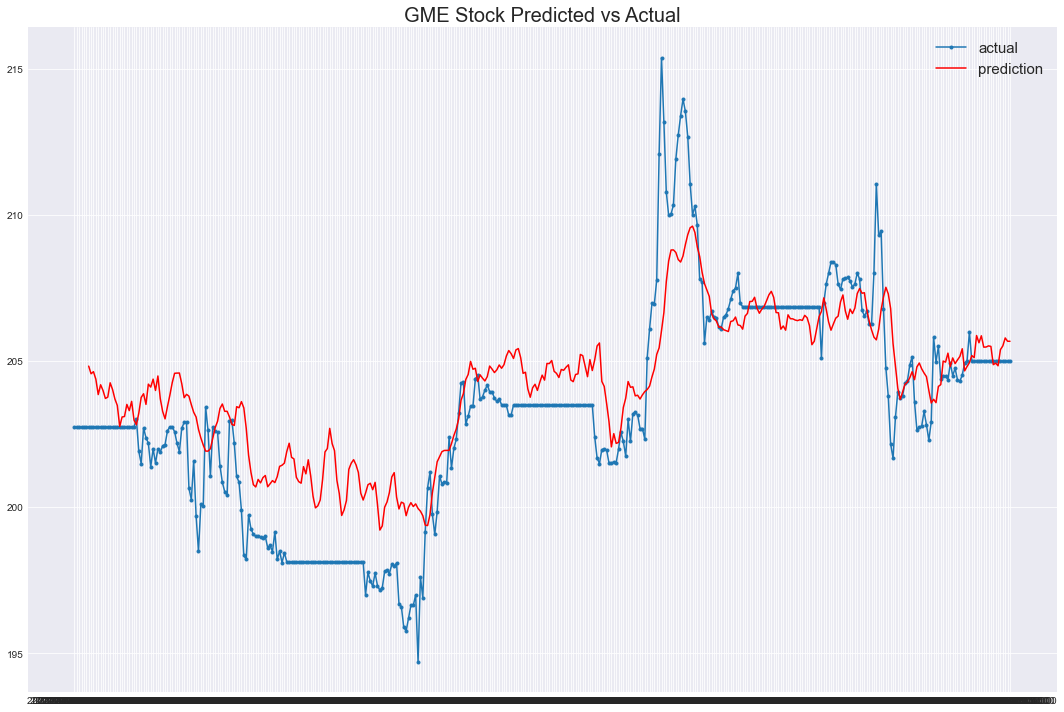

In [56]:
time_y_test  = pd.DataFrame(data = test_price, index = df_gme_final[train_index:].index,columns= [""])

time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[6:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_test,label = "actual",marker='.')
plt.plot(time_y_test_prediction,color="red", label="prediction")
plt.title("GME Stock Predicted vs Actual",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

## AMC

In [99]:
df_amc_prices = df_final[df_final['stock'] == 'AMC']
df_amc_prices = df_amc_prices.drop(columns = ['content'])
df_amc_prices

,date,stock,pre_trading,post_trading,price,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
1582,2021-09-17 20:00:00,AMC,0,1,43.970000,0.160000,-0.2732,34584.878906,34737.859375,5622210000,...,0.0,0.0,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
1583,2021-09-17 20:00:00,AMC,0,1,43.970000,0.000000,0.1280,34584.878906,34737.859375,5622210000,...,0.0,0.0,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
1584,2021-09-17 20:00:00,AMC,0,1,43.970000,0.300000,0.7579,34584.878906,34737.859375,5622210000,...,0.0,0.0,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
1585,2021-09-17 20:00:00,AMC,0,1,43.970000,0.000000,0.0000,34584.878906,34737.859375,5622210000,...,0.0,0.0,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
1586,2021-09-17 20:00:00,AMC,0,1,43.970000,0.000000,0.1513,34584.878906,34737.859375,5622210000,...,0.0,0.0,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62333,2021-08-19 09:30:00,AMC,0,0,36.590000,0.215000,0.6124,34894.121094,34874.671875,3120840000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
62334,2021-08-19 10:00:00,AMC,0,0,35.060001,-0.345833,-0.6597,34894.121094,34874.671875,3120840000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
62335,2021-08-19 10:00:00,AMC,0,0,35.060001,0.300000,0.5106,34894.121094,34874.671875,3120840000,...,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
62557,2021-08-18 13:45:00,AMC,0,0,37.480000,0.000000,0.3818,34960.691406,35310.199219,2965210000,...,0.0,0.0,0.42957,0.000000,0.000000,0.0,0.000000,0.0,0.538773,0.000000


In [100]:
df_amc_prices_mean = df_amc_prices.groupby(['date', 'price'], as_index = False).mean()

In [101]:
df_amc_sentiment = df_amc_prices_mean[['date', 'price', 'pre_trading', 'post_trading', 'Sentiment_textblob', 'Sentiment_vader', 'Close_DJIA', 'Open_DJIA', 'Volume_SnP']]

In [102]:
df_amc_sentiment

,date,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP
0,2021-08-18 13:45:00,37.48,0,0,0.000000,0.381800,34960.691406,35310.199219,2965210000
1,2021-08-18 14:45:00,37.59,0,0,0.000000,0.077200,34960.691406,35310.199219,2965210000
2,2021-08-19 06:30:00,35.62,1,0,0.700000,0.440400,34894.121094,34874.671875,3120840000
3,2021-08-19 07:30:00,35.10,1,0,0.700000,0.440400,34894.121094,34874.671875,3120840000
4,2021-08-19 09:15:00,35.46,1,0,0.000000,-0.542300,34894.121094,34874.671875,3120840000
...,...,...,...,...,...,...,...,...,...
654,2021-09-17 19:00:00,43.91,0,1,0.041470,0.119321,34584.878906,34737.859375,5622210000
655,2021-09-17 19:15:00,43.86,0,1,-0.011979,0.207321,34584.878906,34737.859375,5622210000
656,2021-09-17 19:30:00,43.93,0,1,0.007817,0.138487,34584.878906,34737.859375,5622210000
657,2021-09-17 19:45:00,43.97,0,1,0.042619,0.246682,34584.878906,34737.859375,5622210000


In [103]:
df_amc_tfidf = df_amc_prices[col]

In [104]:
df_amc_final = pd.merge(df_amc_sentiment, df_amc_tfidf, left_on = 'date', right_on = 'date')

In [105]:
df_amc_final = df_amc_final.sort_values('date')

In [106]:
df_amc_final

,date,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,feature_1,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-08-18 13:45:00,37.48,0,0,0.000000,0.381800,34960.691406,35310.199219,2965210000,0.000000,...,0.0,0.00000,0.42957,0.000000,0.000000,0.0,0.000000,0.0,0.538773,0.000000
1,2021-08-18 14:45:00,37.59,0,0,0.000000,0.077200,34960.691406,35310.199219,2965210000,0.000000,...,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,2021-08-19 06:30:00,35.62,1,0,0.700000,0.440400,34894.121094,34874.671875,3120840000,0.000000,...,0.0,0.55871,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,2021-08-19 07:30:00,35.10,1,0,0.700000,0.440400,34894.121094,34874.671875,3120840000,0.000000,...,0.0,0.55871,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,2021-08-19 09:15:00,35.46,1,0,0.000000,-0.542300,34894.121094,34874.671875,3120840000,0.000000,...,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31979,2021-09-17 20:00:00,43.97,0,1,0.065147,0.134261,34584.878906,34737.859375,5622210000,0.158345,...,0.0,0.00000,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
31977,2021-09-17 20:00:00,43.97,0,1,0.065147,0.134261,34584.878906,34737.859375,5622210000,0.158345,...,0.0,0.00000,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
31998,2021-09-17 20:00:00,43.97,0,1,0.065147,0.134261,34584.878906,34737.859375,5622210000,0.158345,...,0.0,0.00000,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154
31987,2021-09-17 20:00:00,43.97,0,1,0.065147,0.134261,34584.878906,34737.859375,5622210000,0.158345,...,0.0,0.00000,0.00000,0.357089,0.325954,0.0,0.283352,0.0,0.191178,0.186154


In [107]:
df_amc_final = df_amc_final.drop_duplicates()

In [108]:
df_amc_nodate = df_amc_final.drop(columns = 'date')

In [109]:
df_amc_nodate

,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,feature_1,feature_2,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,37.48,0,0,0.000000,0.381800,34960.691406,35310.199219,2965210000,0.000000,0.386051,...,0.000000,0.000000,0.429570,0.000000,0.000000,0.000000,0.000000,0.000000,0.538773,0.000000
1,37.59,0,0,0.000000,0.077200,34960.691406,35310.199219,2965210000,0.000000,0.641551,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,35.62,1,0,0.700000,0.440400,34894.121094,34874.671875,3120840000,0.000000,0.397051,...,0.000000,0.558710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,35.10,1,0,0.700000,0.440400,34894.121094,34874.671875,3120840000,0.000000,0.397051,...,0.000000,0.558710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,35.46,1,0,0.000000,-0.542300,34894.121094,34874.671875,3120840000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31875,43.91,0,1,0.041470,0.119321,34584.878906,34737.859375,5622210000,0.208318,0.630765,...,0.118564,0.000000,0.100267,0.352339,0.000000,0.000000,0.186389,0.266728,0.125756,0.000000
31898,43.86,0,1,-0.011979,0.207321,34584.878906,34737.859375,5622210000,0.000000,0.551950,...,0.000000,0.097085,0.076771,0.269774,0.164168,0.374414,0.071356,0.000000,0.000000,0.468786
31929,43.93,0,1,0.007817,0.138487,34584.878906,34737.859375,5622210000,0.000000,0.912757,...,0.133443,0.214065,0.000000,0.066092,0.060330,0.068796,0.000000,0.000000,0.000000,0.068909
31966,43.97,0,1,0.042619,0.246682,34584.878906,34737.859375,5622210000,0.042849,0.741383,...,0.195100,0.052162,0.000000,0.096630,0.088205,0.050292,0.153353,0.146302,0.103467,0.100748


In [110]:
df_amc_price = df_amc_nodate[['price']]
df_amc_price.head()

,price
0,37.48
1,37.59
2,35.62
3,35.10
4,35.46


In [111]:
df_amc_sentiment = df_amc_nodate[['Sentiment_vader']]
df_amc_sentiment.head()

,Sentiment_vader
0,0.3818
1,0.0772
2,0.4404
3,0.4404
4,-0.5423


In [112]:
feat = col[1:]

In [113]:
df_amc_wv = df_amc_nodate[feat]
df_amc_wv.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,0.0,0.386051,0.0,0.000000,0.00000,0.0,0.408582,0.000000,0.457404,0.0,0.0,0.00000,0.42957,0.0,0.0,0.0,0.0,0.0,0.538773,0.0
1,0.0,0.641551,0.0,0.000000,0.76708,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.397051,0.0,0.509384,0.00000,0.0,0.000000,0.520309,0.000000,0.0,0.0,0.55871,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.397051,0.0,0.509384,0.00000,0.0,0.000000,0.520309,0.000000,0.0,0.0,0.55871,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,1.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [114]:
df_amc_index = df_amc_nodate[['Open_DJIA', 'Volume_SnP']]
df_amc_index

,Open_DJIA,Volume_SnP
0,35310.199219,2965210000
1,35310.199219,2965210000
2,34874.671875,3120840000
3,34874.671875,3120840000
4,34874.671875,3120840000
...,...,...
31875,34737.859375,5622210000
31898,34737.859375,5622210000
31929,34737.859375,5622210000
31966,34737.859375,5622210000


In [115]:
price_values = df_amc_price.values.astype('float32')
y = np.reshape(price_values, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

In [116]:
sentiment_values = df_amc_sentiment.values.astype('float32')
sentiment_values = np.reshape(sentiment_values, (-1, 1))

In [117]:
word_vec = df_amc_wv.values.astype('float32')
word_vec = np.reshape(word_vec, (-20, 20))

In [118]:
index_val = df_amc_index.values.astype('float32')
index_val = np.reshape(index_val, (-2, 2))

In [119]:
train_index = int(0.7*len(y))
train_index

461

In [120]:
train_price, test_price = y[:train_index,:], y[train_index:len(y),:]
train_sent, test_sent = sentiment_values[:train_index, :], sentiment_values[train_index: , :]
train_vec, test_vec = word_vec[:train_index, :], word_vec[train_index: , :]
train_ind, test_ind = index_val[:train_index, :], index_val[train_index:, :]

In [121]:
look_back = 5

In [122]:
def hyp(train_price, test_price, train_sent, test_sent, train_vec, test_vec, train_ind, test_ind, look_back):
    price_x_train, price_y_train = create_dataset(train_price, look_back)
    price_x_test, price_y_test = create_dataset(test_price, look_back)
    sent_x_train, sent_y_train = create_dataset(train_sent, look_back)
    sent_x_test, sent_y_test = create_dataset(test_sent, look_back)
    vec_x_train, vec_y_train = create_dataset(train_vec, look_back)
    vec_x_test, vec_y_test = create_dataset(test_vec, look_back)
    ind_x_train, ind_y_train = create_dataset(train_ind, look_back)
    ind_x_test, ind_y_test = create_dataset(test_ind, look_back)
    
    price_x_train = np.reshape(price_x_train, (price_x_train.shape[0], 1, price_x_train.shape[1]))
    price_x_test = np.reshape(price_x_test, (price_x_test.shape[0], 1, price_x_test.shape[1]))
    sent_x_train = np.reshape(sent_x_train, (sent_x_train.shape[0], 1, sent_x_train.shape[1]))
    sent_x_test = np.reshape(sent_x_test, (sent_x_test.shape[0], 1, sent_x_test.shape[1]))
    vec_x_train = np.reshape(vec_x_train, (vec_x_train.shape[0], 1, vec_x_train.shape[1]))
    vec_x_test = np.reshape(vec_x_test, (vec_x_test.shape[0], 1, vec_x_test.shape[1]))
    ind_x_train = np.reshape(ind_x_train, (ind_x_train.shape[0], 1, ind_x_train.shape[1]))
    ind_x_test = np.reshape(ind_x_test, (ind_x_test.shape[0], 1, ind_x_test.shape[1]))
    
    train_some_features = np.append(price_x_train,sent_x_train,axis=1)
    train_more_features = np.append(train_some_features, ind_x_train, axis = 1)
    train_all_features = np.append(train_more_features, vec_x_train, axis = 1)
    test_some_features = np.append(price_x_test,sent_x_test,axis=1)
    test_more_features = np.append(test_some_features, ind_x_test, axis = 1)
    test_all_features = np.append(test_more_features, vec_x_test, axis = 1)
    
    model = LSTM_model(train_all_features, 0.2)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(train_all_features, price_y_train, epochs=25, batch_size=32, validation_data=(test_all_features, price_y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)
    train_predict = model.predict(train_all_features)
    test_predict  = model.predict(test_all_features)
    
    print(f'Lookback: {i}, Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0])))
    print(f'Lookback {i}, Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0])))

In [126]:
price_x_train, price_y_train = create_dataset(train_price, look_back)
price_x_test, price_y_test = create_dataset(test_price, look_back)
sent_x_train, sent_y_train = create_dataset(train_sent, look_back)
sent_x_test, sent_y_test = create_dataset(test_sent, look_back)
vec_x_train, vec_y_train = create_dataset(train_vec, look_back)
vec_x_test, vec_y_test = create_dataset(test_vec, look_back)
ind_x_train, ind_y_train = create_dataset(train_ind, look_back)
ind_x_test, ind_y_test = create_dataset(test_ind, look_back)

In [127]:
price_x_train = np.reshape(price_x_train, (price_x_train.shape[0], 1, price_x_train.shape[1]))
price_x_test = np.reshape(price_x_test, (price_x_test.shape[0], 1, price_x_test.shape[1]))
sent_x_train = np.reshape(sent_x_train, (sent_x_train.shape[0], 1, sent_x_train.shape[1]))
sent_x_test = np.reshape(sent_x_test, (sent_x_test.shape[0], 1, sent_x_test.shape[1]))
vec_x_train = np.reshape(vec_x_train, (vec_x_train.shape[0], 1, vec_x_train.shape[1]))
vec_x_test = np.reshape(vec_x_test, (vec_x_test.shape[0], 1, vec_x_test.shape[1]))
ind_x_train = np.reshape(ind_x_train, (ind_x_train.shape[0], 1, ind_x_train.shape[1]))
ind_x_test = np.reshape(ind_x_test, (ind_x_test.shape[0], 1, ind_x_test.shape[1]))

In [128]:
train_some_features = np.append(price_x_train,sent_x_train,axis=1)
train_more_features = np.append(train_some_features, ind_x_train, axis = 1)
train_all_features = np.append(train_more_features, vec_x_train, axis = 1)
test_some_features = np.append(price_x_test,sent_x_test,axis=1)
test_more_features = np.append(test_some_features, ind_x_test, axis = 1)
test_all_features = np.append(test_more_features, vec_x_test, axis = 1)

In [129]:
model = LSTM_model(train_all_features, 0.2, 123)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [130]:
history = model.fit(train_all_features, price_y_train, epochs=25, batch_size=32, validation_data=(test_all_features, price_y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

In [131]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 4, 50)             11200     
_________________________________________________________________
dropout_87 (Dropout)         (None, 4, 50)             0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 4, 50)             20200     
_________________________________________________________________
dropout_88 (Dropout)         (None, 4, 50)             0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 4, 50)             20200     
_________________________________________________________________
dropout_89 (Dropout)         (None, 4, 50)             0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 50)              

In [132]:
train_predict = model.predict(train_all_features)
test_predict  = model.predict(test_all_features)

In [133]:
print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.027336104
Train Root Mean Squared Error: 0.04223091
Test Mean Absolute Error: 0.03982604
Test Root Mean Squared Error: 0.05507464


In [134]:
df_amc_final = df_amc_final.set_index('date')

In [135]:
train_price = scaler.inverse_transform(train_price)
test_price = scaler.inverse_transform(test_price)

In [136]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

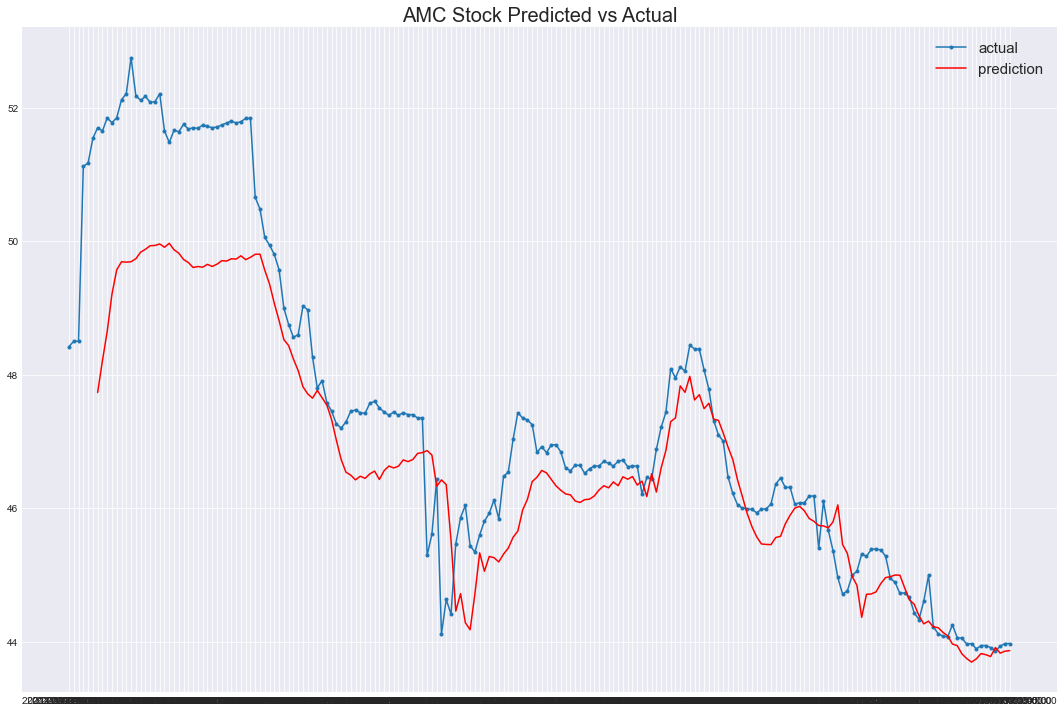

In [137]:
time_y_test  = pd.DataFrame(data = test_price, index = df_amc_final[train_index:].index,columns= [""])

time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[6:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_test,label = "actual",marker='.')
plt.plot(time_y_test_prediction,color="red", label="prediction")
plt.title("AMC Stock Predicted vs Actual",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

## MVIS

In [248]:
df_mvis_prices = df_final[df_final['stock'] == 'MVIS']
df_mvis_prices = df_mvis_prices.drop(columns = ['content'])
df_mvis_prices

,date,stock,pre_trading,post_trading,price,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
3604,2021-09-17 22:30:00,MVIS,0,0,12.8300,0.700,0.6249,34584.878906,34737.859375,5622210000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3605,2021-09-17 21:15:00,MVIS,0,0,12.8300,0.000,0.7783,34584.878906,34737.859375,5622210000,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
3606,2021-09-17 21:00:00,MVIS,0,0,12.8300,0.000,0.7783,34584.878906,34737.859375,5622210000,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
3607,2021-09-17 20:45:00,MVIS,0,1,12.8300,0.000,0.7783,34584.878906,34737.859375,5622210000,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
3608,2021-09-17 20:15:00,MVIS,0,1,12.8300,0.000,0.7783,34584.878906,34737.859375,5622210000,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62565,2021-08-18 20:15:00,MVIS,0,1,13.7900,0.700,0.6249,34960.691406,35310.199219,2965210000,...,0.421177,0.0,0.000000,0.417206,0.0,0.0,0.0,0.000000,0.0,0.434986
62566,2021-08-18 20:15:00,MVIS,0,1,13.7900,0.025,0.2960,34960.691406,35310.199219,2965210000,...,0.421177,0.0,0.000000,0.417206,0.0,0.0,0.0,0.000000,0.0,0.434986
62567,2021-08-18 20:00:00,MVIS,0,1,13.7900,0.000,0.7783,34960.691406,35310.199219,2965210000,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
62568,2021-08-18 12:45:00,MVIS,0,0,13.9501,0.000,0.0000,34960.691406,35310.199219,2965210000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000


In [249]:
df_mvis_prices_mean = df_mvis_prices.groupby(['date', 'price'], as_index = False).mean()

In [250]:
df_mvis_sentiment = df_mvis_prices_mean[['date', 'price', 'pre_trading', 'post_trading', 'Sentiment_textblob', 'Sentiment_vader', 'Close_DJIA', 'Open_DJIA', 'Volume_SnP']]

In [251]:
df_mvis_sentiment

,date,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP
0,2021-08-18 12:45:00,13.9501,0,0,0.0000,0.00000,34960.691406,35310.199219,2965210000
1,2021-08-18 15:00:00,14.0500,0,0,0.0000,0.00000,34960.691406,35310.199219,2965210000
2,2021-08-18 20:00:00,13.7900,0,1,0.0000,0.77830,34960.691406,35310.199219,2965210000
3,2021-08-18 20:15:00,13.7900,0,1,0.3625,0.46045,34960.691406,35310.199219,2965210000
4,2021-08-18 20:45:00,13.7900,0,1,0.0000,0.77830,34960.691406,35310.199219,2965210000
...,...,...,...,...,...,...,...,...,...
833,2021-09-17 20:15:00,12.8300,0,1,0.0000,0.77830,34584.878906,34737.859375,5622210000
834,2021-09-17 20:45:00,12.8300,0,1,0.0000,0.77830,34584.878906,34737.859375,5622210000
835,2021-09-17 21:00:00,12.8300,0,0,0.0000,0.77830,34584.878906,34737.859375,5622210000
836,2021-09-17 21:15:00,12.8300,0,0,0.0000,0.77830,34584.878906,34737.859375,5622210000


In [252]:
df_mvis_tfidf = df_mvis_prices[col]

In [253]:
df_mvis_final = pd.merge(df_mvis_sentiment, df_mvis_tfidf, left_on = 'date', right_on = 'date')


In [254]:
df_mvis_final = df_mvis_final.sort_values('date')

In [255]:
df_mvis_final

,date,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,feature_1,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2021-08-18 12:45:00,13.9501,0,0,0.0000,0.00000,34960.691406,35310.199219,2965210000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000
1,2021-08-18 15:00:00,14.0500,0,0,0.0000,0.00000,34960.691406,35310.199219,2965210000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,2021-08-18 20:00:00,13.7900,0,1,0.0000,0.77830,34960.691406,35310.199219,2965210000,0.841013,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
3,2021-08-18 20:15:00,13.7900,0,1,0.3625,0.46045,34960.691406,35310.199219,2965210000,0.370005,...,0.421177,0.0,0.000000,0.417206,0.0,0.0,0.0,0.000000,0.0,0.434986
4,2021-08-18 20:15:00,13.7900,0,1,0.3625,0.46045,34960.691406,35310.199219,2965210000,0.370005,...,0.421177,0.0,0.000000,0.417206,0.0,0.0,0.0,0.000000,0.0,0.434986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2021-09-17 20:15:00,12.8300,0,1,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
1454,2021-09-17 20:45:00,12.8300,0,1,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
1455,2021-09-17 21:00:00,12.8300,0,0,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
1456,2021-09-17 21:15:00,12.8300,0,0,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000


In [256]:
df_mvis_final = df_mvis_final.drop_duplicates()

In [257]:
df_mvis_nodate = df_mvis_final.drop(columns = 'date')

In [258]:
df_mvis_nodate

,price,pre_trading,post_trading,Sentiment_textblob,Sentiment_vader,Close_DJIA,Open_DJIA,Volume_SnP,feature_1,feature_2,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,13.9501,0,0,0.0000,0.00000,34960.691406,35310.199219,2965210000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000
1,14.0500,0,0,0.0000,0.00000,34960.691406,35310.199219,2965210000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,13.7900,0,1,0.0000,0.77830,34960.691406,35310.199219,2965210000,0.841013,0.0,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
3,13.7900,0,1,0.3625,0.46045,34960.691406,35310.199219,2965210000,0.370005,0.0,...,0.421177,0.0,0.000000,0.417206,0.0,0.0,0.0,0.000000,0.0,0.434986
5,13.7900,0,1,0.0000,0.77830,34960.691406,35310.199219,2965210000,0.841013,0.0,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,12.8300,0,1,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,0.0,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
1454,12.8300,0,1,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,0.0,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
1455,12.8300,0,0,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,0.0,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
1456,12.8300,0,0,0.0000,0.77830,34584.878906,34737.859375,5622210000,0.841013,0.0,...,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000


In [259]:
df_mvis_price = df_mvis_nodate[['price']]
df_mvis_price.head()

,price
0,13.9501
1,14.0500
2,13.7900
3,13.7900
5,13.7900


In [260]:
df_mvis_sentiment = df_mvis_nodate[['Sentiment_vader']]
df_mvis_sentiment.head()

,Sentiment_vader
0,0.00000
1,0.00000
2,0.77830
3,0.46045
5,0.77830


In [261]:
feat = col[1:]
df_mvis_wv = df_mvis_nodate[feat]
df_mvis_wv.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.841013,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000
3,0.370005,0.0,0.0,0.0,0.382728,0.0,0.0,0.419466,0.0,0.0,0.421177,0.0,0.000000,0.417206,0.0,0.0,0.0,0.000000,0.0,0.434986
5,0.841013,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.404794,0.000000,0.0,0.0,0.0,0.358941,0.0,0.000000


In [262]:
df_mvis_index = df_mvis_nodate[['Open_DJIA', 'Volume_SnP']]
df_mvis_index

,Open_DJIA,Volume_SnP
0,35310.199219,2965210000
1,35310.199219,2965210000
2,35310.199219,2965210000
3,35310.199219,2965210000
5,35310.199219,2965210000
...,...,...
1453,34737.859375,5622210000
1454,34737.859375,5622210000
1455,34737.859375,5622210000
1456,34737.859375,5622210000


In [263]:
price_values = df_mvis_price.values.astype('float32')
y = np.reshape(price_values, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

In [264]:
sentiment_values = df_mvis_sentiment.values.astype('float32')
sentiment_values = np.reshape(sentiment_values, (-1, 1))

In [265]:
word_vec = df_mvis_wv.values.astype('float32')
word_vec = np.reshape(word_vec, (-20, 20))

In [266]:
index_val = df_mvis_index.values.astype('float32')
index_val = np.reshape(index_val, (-2, 2))

In [267]:
train_index = int(0.7*len(y))
train_index

586

In [268]:
train_price, test_price = y[:train_index,:], y[train_index:len(y),:]
train_sent, test_sent = sentiment_values[:train_index, :], sentiment_values[train_index: , :]
train_vec, test_vec = word_vec[:train_index, :], word_vec[train_index: , :]
train_ind, test_ind = index_val[:train_index, :], index_val[train_index:, :]

In [269]:
look_back = 5

In [270]:
price_x_train, price_y_train = create_dataset(train_price, look_back)
price_x_test, price_y_test = create_dataset(test_price, look_back)
sent_x_train, sent_y_train = create_dataset(train_sent, look_back)
sent_x_test, sent_y_test = create_dataset(test_sent, look_back)
vec_x_train, vec_y_train = create_dataset(train_vec, look_back)
vec_x_test, vec_y_test = create_dataset(test_vec, look_back)
ind_x_train, ind_y_train = create_dataset(train_ind, look_back)
ind_x_test, ind_y_test = create_dataset(test_ind, look_back)

In [271]:
price_x_train = np.reshape(price_x_train, (price_x_train.shape[0], 1, price_x_train.shape[1]))
price_x_test = np.reshape(price_x_test, (price_x_test.shape[0], 1, price_x_test.shape[1]))
sent_x_train = np.reshape(sent_x_train, (sent_x_train.shape[0], 1, sent_x_train.shape[1]))
sent_x_test = np.reshape(sent_x_test, (sent_x_test.shape[0], 1, sent_x_test.shape[1]))
vec_x_train = np.reshape(vec_x_train, (vec_x_train.shape[0], 1, vec_x_train.shape[1]))
vec_x_test = np.reshape(vec_x_test, (vec_x_test.shape[0], 1, vec_x_test.shape[1]))
ind_x_train = np.reshape(ind_x_train, (ind_x_train.shape[0], 1, ind_x_train.shape[1]))
ind_x_test = np.reshape(ind_x_test, (ind_x_test.shape[0], 1, ind_x_test.shape[1]))

In [272]:
train_some_features = np.append(price_x_train,sent_x_train,axis=1)
train_more_features = np.append(train_some_features, ind_x_train, axis = 1)
train_all_features = np.append(train_more_features, vec_x_train, axis = 1)
test_some_features = np.append(price_x_test,sent_x_test,axis=1)
test_more_features = np.append(test_some_features, ind_x_test, axis = 1)
test_all_features = np.append(test_more_features, vec_x_test, axis = 1)

In [273]:
model = LSTM_model(train_all_features, 0.2)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [274]:
history = model.fit(train_all_features, price_y_train, epochs=25, batch_size=32, validation_data=(test_all_features, price_y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

In [275]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_140 (LSTM)              (None, 4, 50)             11200     
_________________________________________________________________
dropout_139 (Dropout)        (None, 4, 50)             0         
_________________________________________________________________
lstm_141 (LSTM)              (None, 4, 50)             20200     
_________________________________________________________________
dropout_140 (Dropout)        (None, 4, 50)             0         
_________________________________________________________________
lstm_142 (LSTM)              (None, 4, 50)             20200     
_________________________________________________________________
dropout_141 (Dropout)        (None, 4, 50)             0         
_________________________________________________________________
lstm_143 (LSTM)              (None, 50)              

In [276]:
train_predict = model.predict(train_all_features)
test_predict  = model.predict(test_all_features)

In [277]:
print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_train,(price_y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(price_y_test,(price_y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.04256938
Train Root Mean Squared Error: 0.058400244
Test Mean Absolute Error: 0.03868154
Test Root Mean Squared Error: 0.047059674


In [278]:
df_mvis_final = df_mvis_final.set_index('date')

In [279]:
train_price = scaler.inverse_transform(train_price)
test_price = scaler.inverse_transform(test_price)

In [280]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

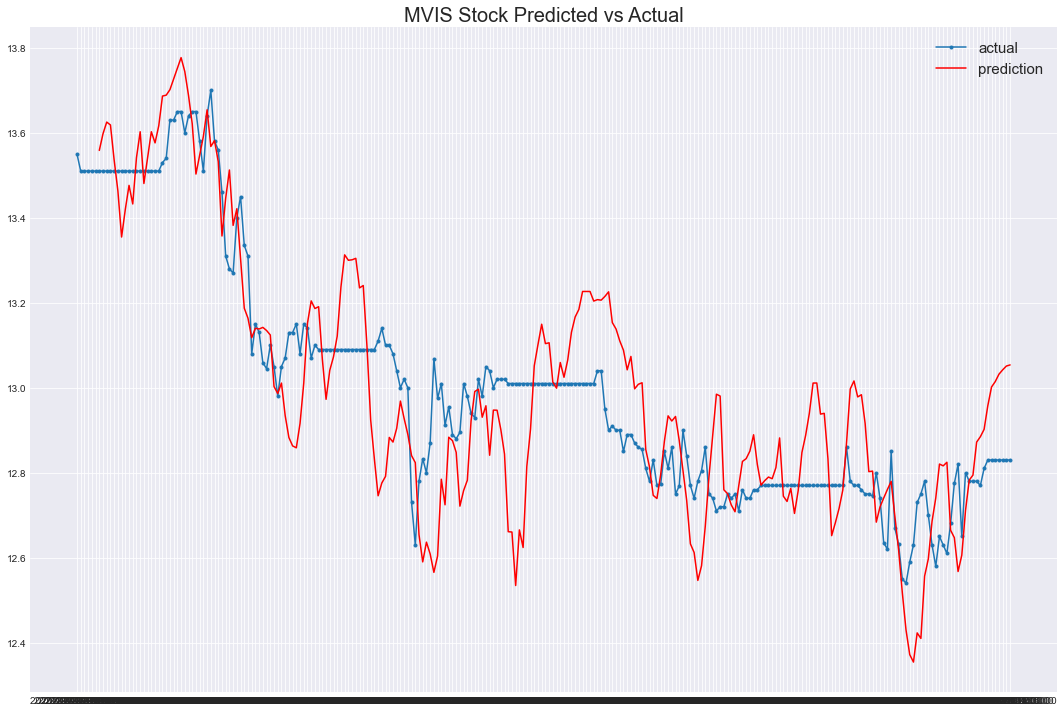

In [281]:
time_y_test  = pd.DataFrame(data = test_price, index = df_mvis_final[train_index:].index,columns= [""])

time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[6:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_test,label = "actual",marker='.')
plt.plot(time_y_test_prediction,color="red", label="prediction")
plt.title("MVIS Stock Predicted vs Actual",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();